In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip


In [2]:
 ! ls '../input/dogs-vs-cats/'

sampleSubmission.csv  test1.zip  train.zip


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np

Using TensorFlow backend.


In [4]:
import zipfile
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/Train')

In [5]:
import zipfile
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/Test')

In [6]:
filenames = os.listdir("/kaggle/working/Train/train")
filenames[0]

'cat.10132.jpg'

In [7]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.10132.jpg,0
1,cat.3705.jpg,0
2,cat.7587.jpg,0
3,cat.10064.jpg,0
4,cat.7088.jpg,0


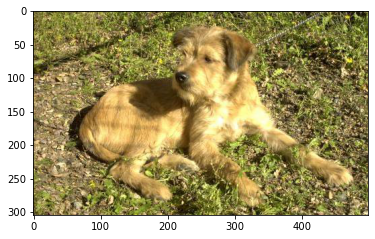

In [8]:
import random
sample = random.choice(filenames)
image = load_img("/kaggle/working/Train/train/"+sample)
plt.imshow(image)

In [9]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

In [10]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

In [11]:
#https://keras.io/api/applications/vgg/#vgg16-function
vgg = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 2s 0us/step


In [12]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [13]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [14]:
prediction = Dense(2, activation='softmax')(x)

In [15]:
model = Model(vgg.input, outputs=prediction)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

In [17]:
# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [18]:
total_train,total_validate

(22500, 2500)

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [20]:
train_df['category'] = train_df['category'].astype(str)# as per https://github.com/keras-team/keras-preprocessing/issues/152, category columns needs to be converted into string

In [21]:
validate_df['category'] = validate_df['category'].astype(str)

In [22]:
type(df['category'])

pandas.core.series.Series

In [23]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/Train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/Train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [25]:
len(validation_generator)

157

In [26]:
len(train_generator)

1407

Found 4 validated image filenames belonging to 2 classes.


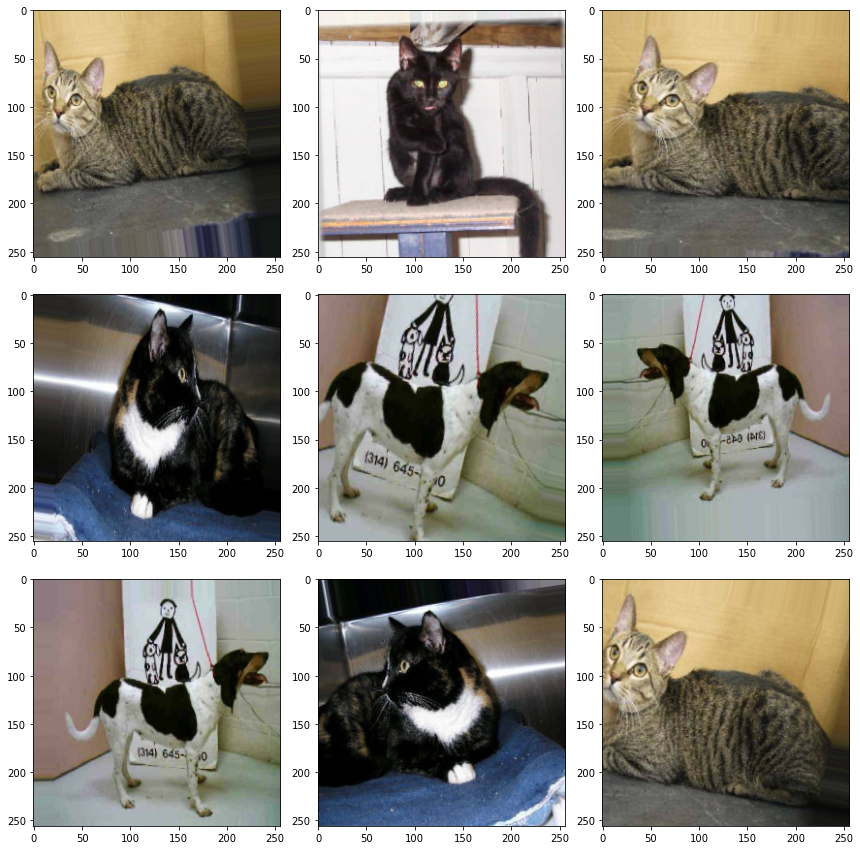

In [27]:
#generated images examples
example_df = train_df.sample(n=4).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/kaggle/working/Train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [28]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
1406/1406 [==============================] - 395s 281ms/step - loss: 0.3500 - accuracy: 0.8443 - val_loss: 0.2697 - val_accuracy: 0.9054
Epoch 2/5
1406/1406 [==============================] - 390s 277ms/step - loss: 0.2698 - accuracy: 0.8865 - val_loss: 0.2890 - val_accuracy: 0.9259
Epoch 3/5
1406/1406 [==============================] - 389s 276ms/step - loss: 0.2450 - accuracy: 0.8977 - val_loss: 0.1609 - val_accuracy: 0.9207
Epoch 4/5
1406/1406 [==============================] - 388s 276ms/step - loss: 0.2305 - accuracy: 0.9018 - val_loss: 0.1108 - val_accuracy: 0.9211
Epoch 5/5
1406/1406 [==============================] - 388s 276ms/step - loss: 0.2234 - accuracy: 0.9074 - val_loss: 0.1534 - val_accuracy: 0.9344


In [29]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.933494  ;  loss = 0.262529 


In [31]:
history.history['loss']

[0.34997667566013385,
 0.26962193619778646,
 0.24471576268764986,
 0.2305838166169585,
 0.22352369097183233]

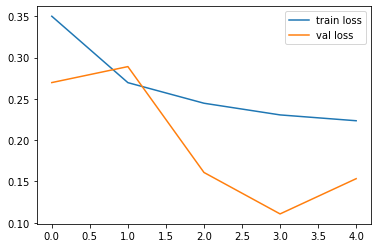

<Figure size 432x288 with 0 Axes>

In [32]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

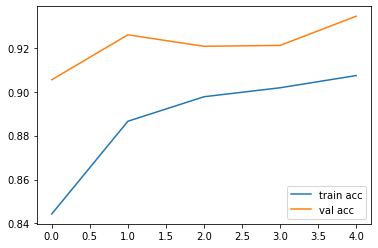

<Figure size 432x288 with 0 Axes>

In [35]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [40]:
import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')

In [41]:
ls

AccVal_acc.png    Test/   __notebook_source__.ipynb
LossVal_loss.png  Train/  facefeatures_new_model.h5
